In [126]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
from catboost import CatBoostRegressor
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [127]:
os.chdir("/Users/SDia/Documents/Data/")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# from this kernel: https://www.kaggle.com/gravix/gradient-in-a-box
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [128]:
# Replacing the belongs_to_collection column for collection_name and has_collection

train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

In [129]:
# Replacing the "genres" column with num_genres and all_genres. Also adding logical columns for the 15 most common genres 

list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)


,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1,4,Comedy Drama Family Romance,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1200000,http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,0,0,2,Drama Thriller,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,0,0,2,Action Thriller,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [130]:
# Replacing production_companies with 30 logical column for the most common companies. Also adding a column for the number of companies.

list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

In [131]:
# Replacing production_countries with the 25 logical columns for the most common production countries. Also adding a column for the number of countries. 

list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

In [132]:
# Replacing spoken_languages with 30 logical columns for the most common spoken languages. Also adding a column for the number of keywords.

list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

In [133]:
# Replacing "Keywords" with 30 logical columns for the most common keywords. Also adding a column for the number of keywords.

list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

In [134]:
# Replacing "cast" with 15 logical column for the most common cast characters. Also adding a column for the number of cast members. 
# Adding 3 column for the number of males and female cast. 

list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
for g in top_cast_names:
    test['cast_name_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,crew,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_Keywords,keyword_woman director,keyword_independent film,keyword_duringcreditsstinger,keyword_murder,keyword_based on novel,keyword_violence,keyword_sport,keyword_biography,keyword_aftercreditsstinger,keyword_dystopia,keyword_revenge,keyword_friendship,keyword_sex,keyword_suspense,keyword_sequel,keyword_love,keyword_police,keyword_teenager,keyword_nudity,keyword_female nudity,keyword_drug,keyword_prison,keyword_musical,keyword_high school,keyword_los angeles,keyword_new york,keyword_family,keyword_father son relationship,keyword_kidnapping,keyword_investigation,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_c

In [135]:
# Replacing "crew" with the 15 logical columns for the most common crew names. Also adding a column for the number of crew members.
# Adding 2 columns for the number of males and females in each column.

list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
list_of_crew_names = train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values

train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_crew_names:
    test['crew_name_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

 Un-logged revenue

In [136]:
# Revenue and budget are highly skewed so I took the logarithm of borth to make them more normal.

#train['log_revenue'] = np.log1p(train['revenue'])
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

In [137]:
# Creating a logical column for having a homepage

train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

In [138]:
# Simple first model (linear regression)
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')


Weight?,Feature
+1145601432.884,shaw
+866207124.078,emerges
+852587463.799,revenge against
+737867966.369,amazon
+624492988.028,helps him
+607869013.600,seeks
+588180136.042,x
+587490557.819,aided by
+584240956.160,gotham
+575808394.412,villainous


In [139]:
# fixing the format of dates in release_date and turning it into a panda datetime variable. 

test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/98'
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year
    
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [140]:
# creating features based on dates (year, weekday, month, weekofyear, day, quarter)
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

train = process_date(train)
test = process_date(test)

In [141]:
# Modeling and feature engineering SKIPPING PARTS so redo
# add log revenue to list ot 
train = train.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1) 
test = test.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)

In [142]:
# Removing columns that only have 1 unique value

for col in train.columns:
    if train[col].nunique() == 1:
        print(col)
        train = train.drop([col], axis=1)
        test = test.drop([col], axis=1)

language_
cast_character_


In [143]:
for col in ['original_language', 'collection_name', 'all_genres']:
    le = LabelEncoder()
    le.fit(list(train[col].fillna('')) + list(test[col].fillna('')))
    train[col] = le.transform(train[col].fillna('').astype(str))
    test[col] = le.transform(test[col].fillna('').astype(str))

In [144]:
train_texts = train[['title', 'tagline', 'overview', 'original_title']]
test_texts = test[['title', 'tagline', 'overview', 'original_title']]

In [145]:
# Remove the text columns (title, tagline, overview, origional_title) and replace them with columns for their length of characters and length of words. 
for col in ['title', 'tagline', 'overview', 'original_title']:
    train['len_' + col] = train[col].fillna('').apply(lambda x: len(str(x)))
    train['words_' + col] = train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    train = train.drop(col, axis=1)
    test['len_' + col] = test[col].fillna('').apply(lambda x: len(str(x)))
    test['words_' + col] = test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test = test.drop(col, axis=1)

undid log-revenue

In [146]:
# Splitting the training data into training and validation

X = train.drop(['id', 'revenue'], axis=1)
#y = np.log1p(train['revenue'])
y = train['revenue']
X_test = test.drop(['id'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)


In [147]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [148]:
# Creating a function for the RMSLE metric

def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False
  


Fold 0 started at Wed May 15 12:09:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[393]	valid_0's rmse: 4.87065e+07	valid_1's rmse: 6.63478e+07
Fold 1 started at Wed May 15 12:09:47 2019
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 3.49712e+07	valid_1's rmse: 7.13958e+07
Early stopping, best iteration is:
[1447]	valid_0's rmse: 2.94805e+07	valid_1's rmse: 7.11696e+07
Fold 2 started at Wed May 15 12:09:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[799]	valid_0's rmse: 3.78676e+07	valid_1's rmse: 6.77366e+07
Fold 3 started at Wed May 15 12:09:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[712]	valid_0's rmse: 3.90934e+07	valid_1's rmse: 8.37877e+07
Fold 4 started at Wed May 15 12:09:55 2019
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's r

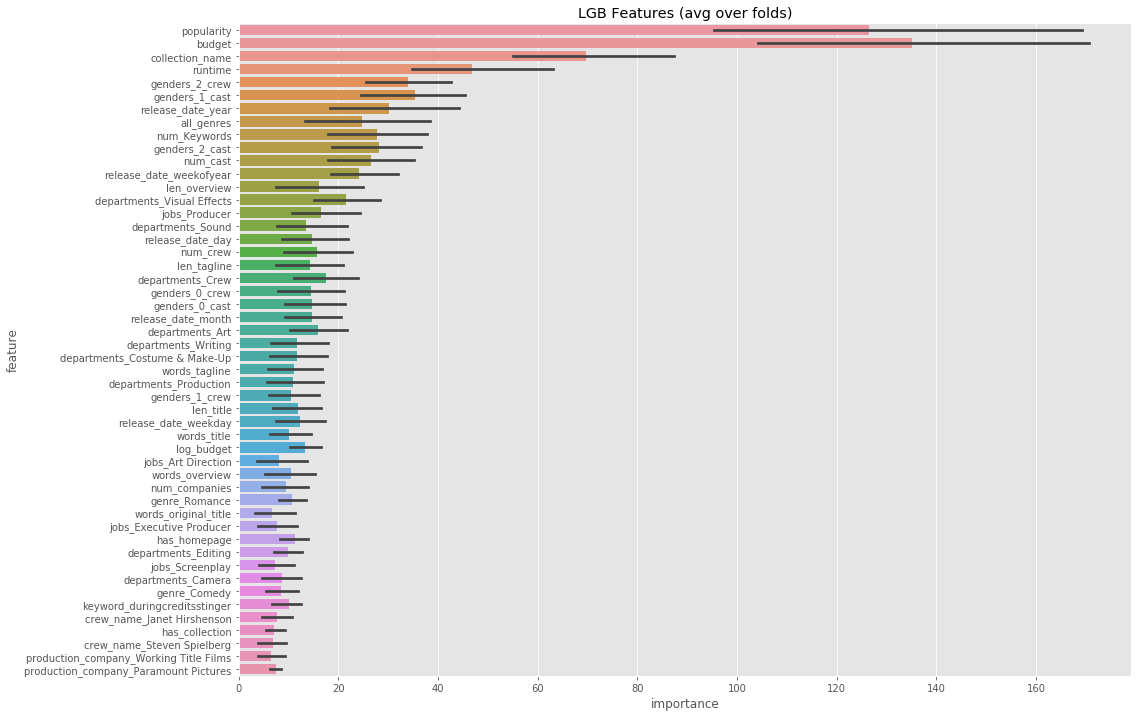

In [151]:
# Setting the parameters for LightGBM and training the model.

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

In [ ]:
# Replacing the revenue column in the sample_submission.csv file with the predicted values from the above LightGBM model

sub = pd.read_csv('sample_submission.csv')
sub['revenue'] = prediction_lgb
sub.to_csv("lgb.csv", index=False)